# Topic Modelling - LDA

In [42]:
redditfile = 'Movie_AllComments_Final.json'
redditFile = 'Movie_AllComments_Final.json'

In [44]:
#all the codes from this file are retrieved from Social Media and Network Analytics, Lab Notes 

import json
import pandas as pd
from nltk import ngrams
from collections import Counter
import nltk
import string
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
import numpy as np
import math
import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

# Clening processes
tweetTokeniser = nltk.tokenize.TweetTokenizer()
lPunct = list(string.punctuation)
lStopwords = nltk.corpus.stopwords.words('english') + lPunct + ['rt', 'via', '..', '...', '"', "'", '`', '’', 'http', 'https','com', 'www', 'co', 'amp','could', 'would','giphy']

tweetLemmatizer = nltk.stem.WordNetLemmatizer()

lTitles = []  
lComments = []  
lCombined = []

def processText(text, tweetTokeniser, tweetLemmatizer, lStopwords):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  
    tokens = tweetTokeniser.tokenize(text.lower())     
    return [tweetLemmatizer.lemmatize(token) for token in tokens if token not in lStopwords and not token.isdigit()]

# Load data
with open(redditFile, 'r', encoding='utf-8') as f:
    redditDump = json.load(f)

for submission in redditDump['submissions']:
    postDate = pd.to_datetime(submission['created'])

    # ----- Process submission title -----
    title_text = submission.get('title', '')
    title_text = re.sub(u"(\u2018|\u2019|\u2014)", "", title_text)
    lTokens_title = processText(title_text, tweetTokeniser, tweetLemmatizer, lStopwords)
    lTitles.append(' '.join(lTokens_title))

    # ----- Process all comments -----
    all_comment_tokens = []
    for comment in submission.get('comments', []):
        comment_text = comment.get('body', '')
        comment_text = re.sub(u"(\u2018|\u2019|\u2014)", "", comment_text)
        tokens = processText(comment_text, tweetTokeniser, tweetLemmatizer, lStopwords)
        all_comment_tokens.extend(tokens)

    lComments.append(' '.join(all_comment_tokens))

    # ----- Combine title and comment tokens -----
    combined_tokens = lTokens_title + all_comment_tokens
    lCombined.append(' '.join(combined_tokens))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nadiatoo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
# Manully choose the optimal number
topicNum = 9
wordNumToDisplay = 20
featureNum = 1500

In [62]:
tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words='english')
tf = tfVectorizer.fit_transform(lCombined)

tfFeatureNames = tfVectorizer.get_feature_names_out()

ldaModel = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)

In [49]:
def display_topics(model, featureNames, numTopWords):
    """
    Prints out the most associated words for each feature.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    @param numTopWords: number of words to print per topic.
    """

    for topicId, lTopicDist in enumerate(model.components_):
        print("Topic %d:" % (topicId))
        print(" ".join([featureNames[i] for i in lTopicDist.argsort()[:-numTopWords - 1:-1]]))

In [63]:
display_topics(ldaModel, tfFeatureNames, wordNumToDisplay)

Topic 0:
unattractive look like personality movie attractive ugly make shes think white snow people rachel costume pretty face gal zegler person
Topic 1:
gif flynn shang frollo li eugene love rider universally villain han prince despised like character think people movie vote controversial
Topic 2:
like movie white snow disney look critic gif review dwarf people action ai live paid cgi love say think know
Topic 3:
love square white snow gorgeous hanfu like beautiful disney look pretty really chinese want princess style need dress weve buy
Topic 4:
movie book like theater time list year read film mickey good people great series really going think make new know
Topic 5:
white look like snow movie hair better make costume rachel disney dwarf dress people really think color original thing time
Topic 6:
cinderella dress belle movie elsa lebanon white snow iconic banned like acting princess think say people gal aurora ariel ban
Topic 7:
movie disney like snow white film people live action re

In [64]:
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=8601) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=8601) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=8601) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=8601) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: T

# Wordcloud

In [68]:
def displayWordcloud(model, featureNames):
    """
    Displays the word cloud of the topic distributions, stored in model.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    """
    normalisedComponents = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]

    numTopics = len(model.components_)
    plotCols = 4
    plotRows = int(math.ceil(numTopics / plotCols))
    
    topicNum = len(model.components_)

    plotColNum = 3

    plotRowNum = int(math.ceil(topicNum / plotColNum))
    plt.figure(figsize=(plotCols * 5, plotRows * 4))

    for topicId, lTopicDist in enumerate(normalisedComponents):
        lWordProb = {featureNames[i] : wordProb for i,wordProb in enumerate(lTopicDist)}
        wordcloud = WordCloud(background_color='black')
        wordcloud.fit_words(frequencies=lWordProb)
        plt.subplot(plotRowNum, plotColNum, topicId+1)
        plt.title('Topic %d:' % (topicId+1))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")

    plt.show(block=True)


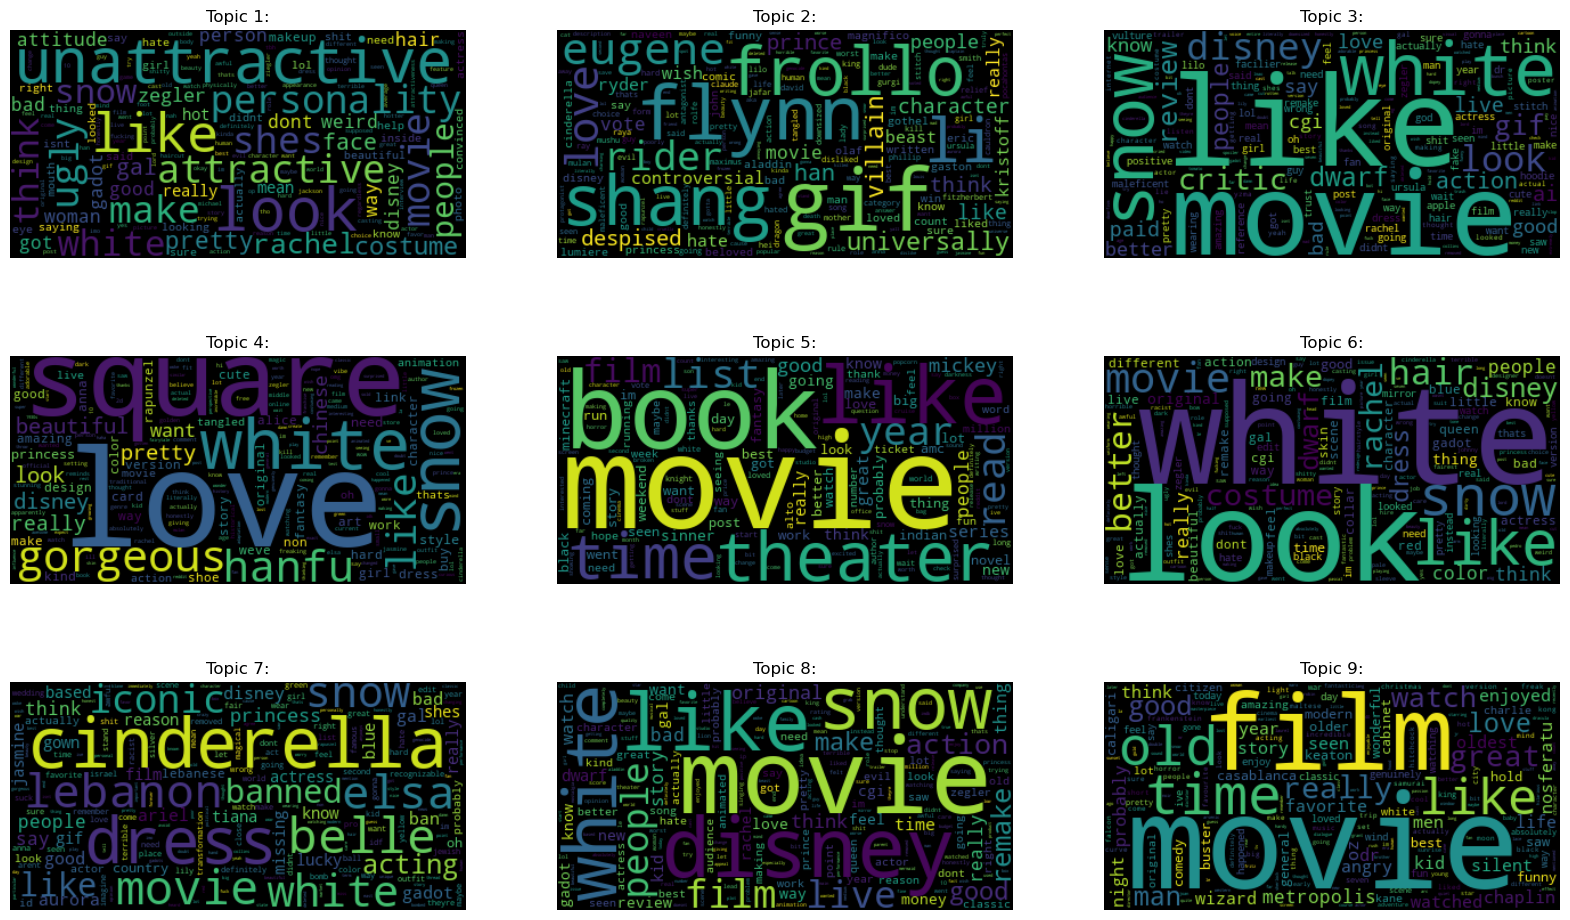

In [70]:
displayWordcloud(ldaModel, tfFeatureNames)